In [1]:
from __future__ import division
from PIL.Image import open
from numpy import array
from pandas import DataFrame as df
from skimage.exposure import histogram
from matplotlib.pyplot import subplots, tight_layout


In [2]:
# Toy example
im_hist = {0:8, 1:7, 2:2, 3:6, 4:9, 5:4}
mn = 36

In [3]:
# Loading Image
path = r"images\coins.png"
im = array(open(path).convert('L'))

#Image size
m,n = im.shape
mn = m*n

In [4]:
# Calculating histogram

im_hist = dict()
freq, bins = histogram(im)
im_hist.update(zip(bins,freq))

In [5]:
def between_variance(q1, u1, u2, variances=list()):
    '''
    Implementation of the recursive Between Class Variance method

    variances (output):
        contains a list of the Between-Variances for each threshold
    '''
    bin_ = im_hist.popitem()
    
    t = bin_[0]
    # P(t)
    pt = bin_[1] / mn
    
    between_variance_ = (q1 * (1 - q1) * (u1 - u2)**2)
    variances.append((t, between_variance_))
    
    # The base case
    # Instead of q1==1
    # If 'im_hist' is empty
    if not im_hist:
        return variances
    
    # q1(t+1)
    q1_t_1 = q1 + pt
        
    # u1(t+1)
    u1_t_1 = (q1 * u1 + (t)*pt) / q1_t_1
    # u2(t+1)
    u2_t_1 = (u - (q1_t_1 * u1_t_1)) / (1 - q1_t_1)

    return between_variance(q1_t_1, u1_t_1, u2_t_1, variances)


In [6]:
# Calculating u
u =  0
for (t, pt) in im_hist.items():
    u = u + t * pt
u = u/mn

In [7]:
# Initialization
thresh = between_variance(q1=0, u1=0, u2=u)

In [8]:
def maximize_bv(variances):
    '''
    Seperate variances from thresholds
    Get the variance with the maximum value
    Get the index of that variance
    Get the threshold at that index
    '''
    t, V = zip(*variances)
    return t[V.index(max(V))]

In [9]:
# The pixel intensity that maximizes the Between-class variance
otsu_thresh =  maximize_bv(thresh)

print 'Threshold =', otsu_thresh

Threshold = 126


In [10]:
# Visualization

#seperating bins and variances
t, V = zip(*thresh)
variances = df(data=[V], columns=t, index=['V'])

def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    https://pandas.pydata.org/pandas-docs/stable/style.html
    '''
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

variances.style.apply(highlight_max, axis=1)

,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255
V,0,0.0978187,0.384413,0.477674,0.841751,0.930544,1.45016,1.78795,2.11713,2.43779,2.82808,3.7404,4.48066,5.48926,6.75109,7.29626,8.48806,9.38847,10.7624,11.8534,13.0291,14.2828,15.6634,16.3047,17.2862,18.6848,20.037,21.6236,23.2917,24.9891,26.4159,28.4386,41.083,55.5756,83.4349,119.121,143.902,174.774,201.921,229.577,278.394,336.145,393.863,459.838,518.356,574.295,633.165,686.348,741.549,811.76,869.554,932.19,1009.1,1142.81,1322.03,1558.73,1800.15,2164.66,2504.91,2659.67,2706.1,2725.67,2739.85,2749.37,2757.1,2763.82,2768.6,2773.99,2778.34,2781.47,2784.41,2787.91,2790.81,2793.52,2796.36,2798.74,2802.15,2804.74,2808.29,2810.64,2812.91,2814.95,2816.68,2819.43,2822.29,2824.56,2827,2829.45,2831.97,2834.37,2836.59,2838.6,2840.44,2842.58,2845.13,2846.92,2849.39,2851.61,2853.4,2854.92,2856.26,2857.12,2858.44,2859.22,2859.84,2860.54,2861.07,2861.33,2861.47,2861.47,2861.3,2861.01,2860.55,2859.9,2858.88,2857.97,2856.75,2855.18,2853.43,2851.56,2849.31,2846.93,2844.87,2841.89,2838.41,2834.12,2830.71,2826.76,2822.05,2816.55,2811.19,2806.14,2798.29,2792.53,2784.67,2775.49,2765.55,2755.66,2743.86,2732.84,2719.79,2705.25,2689.25,2672.75,2655.37,2635.47,2615.32,2596.43,2570.79,2540.74,2513.03,2482.04,2453.07,2417.74,2379,2335.11,2287.66,2243.34,2190.26,2135.84,2080.19,2019.63,1955.42,1892.74,1828.68,1767.98,1705.62,1648.09,1593.15,1532.34,1479.45,1430.56,1378.41,1329.05,1282.49,1238.1,1191.25,1151.86,1111.46,1075.26,1040.55,1009.9,974.812,942.752,911.875,880.719,856.401,829.552,804.182,778.907,752.291,728.88,703.457,678.169,654.903,630.599,603.662,576.533,555.533,531.839,507.811,480.059,457.861,438.45,420.722,403.531,384.87,366.969,348.394,329.768,313.882,297.985,280.097,265.763,249.41,236.512,220.162,208.794,195.103,185.116,169.804,156.288,147.914,138.392,128.476,116.046,107.201,96.8776,89.4433,79.1186,70.6363,64.619,55.0381,49.1551,43.7901,38.0523,32.2397,27.2814


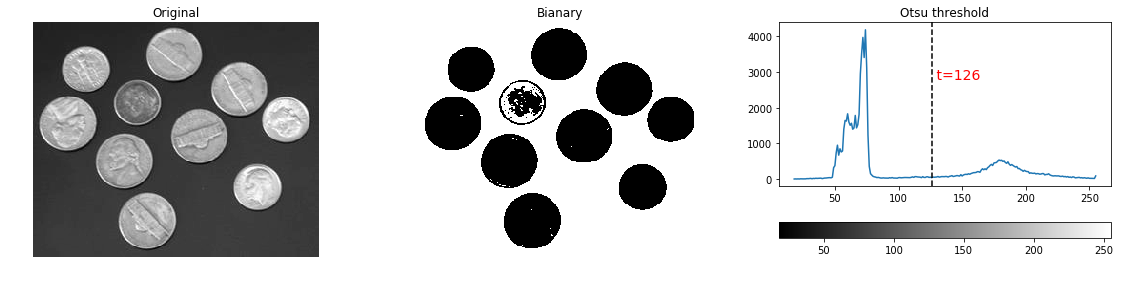

In [11]:
f, (original, binary, thres) = subplots(nrows=1, ncols=3, figsize=(16,4))

mapp = original.imshow(im, cmap='gray')
original.set_title('Original'),original.axis('off')
binary.imshow(im<otsu_thresh, cmap='gray'),binary.set_title('Bianary'),binary.axis('off')
thres.plot(bins, freq),thres.axvline(otsu_thresh,color='k',linestyle='dashed'),thres.set_title('Otsu threshold')
thres.text(x=otsu_thresh,y=freq.max()*2/3 ,s=' t='+str(otsu_thresh),color='r', fontsize=14),thres.axis('on')
f.colorbar(mapp, ax=thres, orientation='horizontal')
tight_layout()